In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [2]:
from kan import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from functions import get_mean_pulse_from_set, momentos, gauss, gauss_fit, move_to_reference, delay_pulse_pair, create_and_delay_pulse_pair
from Models import model_definition

2024-06-17 15:57:13.108014: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 15:57:13.131617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 15:57:13.556799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [5]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo, V28, kind = 'cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo, V55, kind = 'cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo, V82, kind = 'cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

REALS = np.concatenate((new_V28, new_V55, new_V82), axis = 0)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


Text(0, 0.5, 'Voltage [A.U]')

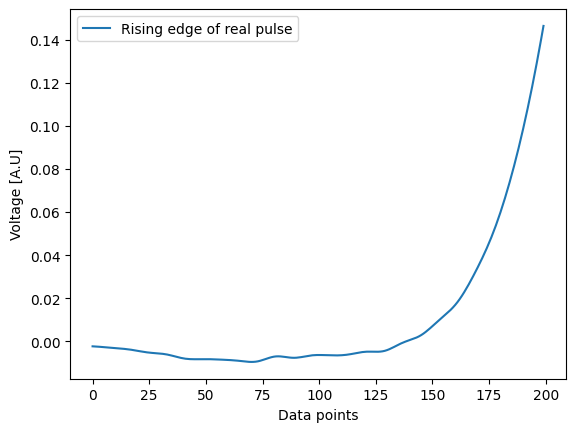

In [6]:
start = 50 * EXTRASAMPLING
stop = 75 * EXTRASAMPLING
plt.plot(new_V55[0,start:stop,0], label = 'Rising edge of real pulse')

plt.legend()
plt.xlabel('Data points')
plt.ylabel('Voltage [A.U]')

In [7]:
trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(REALS[:,start:stop,0], new_time_step, delay_steps = 20, NOISE = True)
trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(REALS[:,start:stop,1], new_time_step, delay_steps = 20, NOISE = True)

In [8]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)
M_Train_dec1 = momentos(trainX_dec1)

#-------------------------------------------------------------- Normalize ---------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)


#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Min detector 0:", min_dec0)
print("Max detector 0:", max_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Min detector 1:", min_dec1)
print("Max detector 1:", max_dec1)

(736, 12, 2) NM = 12
Min detector 0: -0.6335273961413672
Max detector 0: 12.94087516545217
(736, 12, 2) NM = 12
Min detector 1: -0.874928527069751
Max detector 1: 11.258203073581658


In [10]:
dataset = {}
dataset['train_input'] = torch.from_numpy(M_Train_dec0[:500,:,0])
dataset['train_label'] = torch.from_numpy(np.expand_dims(REF_train_dec0[:500], axis = -1))
dataset['test_input'] = torch.from_numpy(M_Train_dec0[500:,:,0])
dataset['test_label'] = torch.from_numpy(np.expand_dims(REF_train_dec0[500:], axis = -1))

print(dataset['train_input'].shape, dataset['train_label'].shape)

torch.Size([500, 12]) torch.Size([500, 1])


In [11]:
model = KAN(width = [12, 3, 2], grid = 5, k = 3, seed = 0)

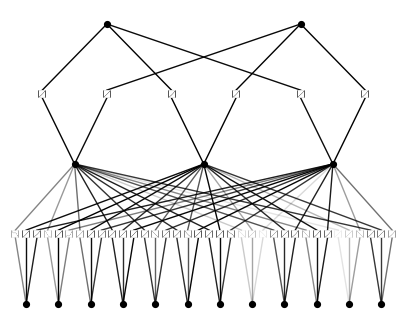

In [12]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [13]:
# train the model
model.train(dataset, opt = "LBFGS", steps = 20, lamb = 0.01, lamb_entropy = 10.);

train loss: 2.09e-01 | test loss: 2.07e-01 | reg: 1.57e+01 : 100%|██| 20/20 [00:04<00:00,  4.99it/s]


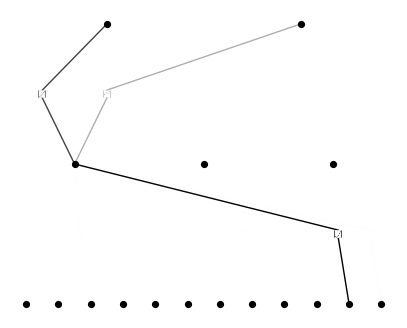

In [14]:
model.prune()
model.plot(mask = True)

In [15]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib = lib)

fixing (0,0,0) with x^4, r2=0.7759579879939743
fixing (0,0,1) with tanh, r2=0.8841662750357737
fixing (0,0,2) with sin, r2=0.931231401255928
fixing (0,1,0) with exp, r2=0.9370458289941059
fixing (0,1,1) with tanh, r2=0.9388736852729316
fixing (0,1,2) with x^2, r2=0.7598017612942982
fixing (0,2,0) with x^3, r2=0.8620086305927515
fixing (0,2,1) with x^3, r2=0.8037450301756921
fixing (0,2,2) with x^3, r2=0.31842963228393467
fixing (0,3,0) with exp, r2=0.8366964934277963
fixing (0,3,1) with x^4, r2=0.9715099983173882
fixing (0,3,2) with log, r2=0.60916107881922
fixing (0,4,0) with x^2, r2=0.6391680868615454
fixing (0,4,1) with x^4, r2=0.9516601333735469
fixing (0,4,2) with x^4, r2=0.5028570467338626
fixing (0,5,0) with log, r2=0.13710373229419745
fixing (0,5,1) with x^4, r2=0.9284651857157917
fixing (0,5,2) with x^4, r2=0.9436290700641773
fixing (0,6,0) with x^4, r2=0.8106823442551908
fixing (0,6,1) with tanh, r2=0.6680253030177874
fixing (0,6,2) with tanh, r2=0.7423125533568596
fixing (0,

In [16]:
model.symbolic_formula()[0][0]

0.02 - 0.05*sin(15.49*(0.16 - x_9)**4 - 17.35*(0.18 - x_8)**4 - 2.28*(0.22 - x_3)**3 - 0.13*(0.22 - x_5)**2 + 9.13*(0.27 - x_10)**4 + 3.57*(0.28 - x_7)**4 + 1.69*(0.29 - x_1)**4 - 5.39*Abs(9.38*x_11 - 0.41) + 0.01*Abs(10.0*x_12 - 1.84) - 5.07)